In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

In [21]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
SOS_token = 0 #start of sequence
EOS_token = 1 #end of sequence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:"SOS", 1:"EOS"}
        self.n_words = 2    # SOS, EOS 포함 단어 갯수
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
        
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        

In [5]:
#unicode -> ASCII 변환
#관용구처럼 사용하는 소스라고 함
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [6]:
#양쪽 공백 떼기, 소문자로 바구기, 정규표현식으로 a~z~A~Z제외 잘라내기

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("reading lines...")
    
    #파일 읽은 뒤 줄단위로 분리
    lines = open('text_data/%s-%s.txt' % (lang1, lang2), encoding = 'utf-8').\
        read().strip().split('\n')
    
    #한 줄을 쌍으로 저장
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    #reverse가 true일 때에는 pair를 뒤집음
    #Lang클래스의 인스턴스를 각 lang으로 생성한 뒤 리턴
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

In [8]:
#빠른 학습을 위해 문장 길이 MAX_LENGTH보다 짧은 문장만 남길 것임
MAX_LENGTH = 15

#빠른 학습을 위해 i am 과 i'm을 같은 형태로 시작하는 문장만 남길 것임, 어퍼스트로피는 이미 지워놨음
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
#전체 데이터 전처리 과정 통합 실행 함수
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("counted words:")
    print("input:", input_lang.name, input_lang.n_words)
    print("output:", output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

reading lines...
Read 135842 sentence pairs
Trimmed to 13201 sentence pairs
Counting words...
counted words:
input: fra 5245
output: eng 3466
['je suis medecin .', 'i m a doctor .']


In [10]:
#encoder는 입력되는 모든 단어에 대해 특정 값을 출력함
class EncoderRnn(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRnn, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size, device = device)

In [11]:
#decoder는 encoder의 출력을 받아 단어 시퀀스를 출력함
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [25]:
#단순 디코더 대신 어텐션 디코더 도입, 어텐션 디코더는 인코딩에서 전해진 단일벡터만을 보는 것이 아니라고 하는데..
class AttnDecoderRnn(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRnn, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]),1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output,hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size, device = device)
        
        

In [13]:
#학습을 위해 input tensor와 target tensor를 생성함
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [23]:
#teacher_forcing_ratio는 디코더의 예측을 다음 입력으로 넣는 대신 실제 목표 출력을 다음 입력으로 넣는 비율
#이 값이 올라가면 주어진 문장 형태에 대한 학습은 잘 이뤄지나 새로운 형태의 문장은 잘 못 다룸

teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
         criterion, max_length = MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0,0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random()<teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  #forcing 작동
        
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() #입력으로 사용한 부분을 히스토리에서 분리
            
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
            
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

In [15]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
#학습 과정
#1.타이머 시작
#2.optimizers, criterion 초기화
#3.학습 pairs 생성
#4.비어있는 loss 배열 초기화

def trainIters(encoder, decoder, n_iters,
               print_every = 1000, plot_every = 100, learning_rate = 0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # 매 print_every마다 다시 0으로 초기화
    plot_loss_total = 0 # 매 plot_every 마다 다시 0으로 초기화
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr = learning_rate)
    #SGD : stochastic gradient descent, 미니배치 형태로 진행하는 옵티마이저
    #이거 대신 아담옵티마이저로 가면 더 나은 결과를 기대할 수 있음
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)    

In [17]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device = device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0,0]
        
        decoder_input = torch.tensor([[SOS_token]], device = device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:di+1]
    

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

3m 52s (- 54m 12s) (5000 6%) 3.0662
7m 44s (- 50m 17s) (10000 13%) 2.5392
11m 36s (- 46m 24s) (15000 20%) 2.2186
15m 28s (- 42m 32s) (20000 26%) 1.9929
19m 25s (- 38m 50s) (25000 33%) 1.8626
23m 23s (- 35m 4s) (30000 40%) 1.6837
27m 23s (- 31m 17s) (35000 46%) 1.5803
31m 32s (- 27m 36s) (40000 53%) 1.4830
35m 36s (- 23m 44s) (45000 60%) 1.3713
39m 38s (- 19m 49s) (50000 66%) 1.2914
43m 35s (- 15m 51s) (55000 73%) 1.2071
47m 34s (- 11m 53s) (60000 80%) 1.1218
109m 8s (- 16m 47s) (65000 86%) 1.0518
113m 2s (- 8m 4s) (70000 93%) 1.0152
116m 56s (- 0m 0s) (75000 100%) 1.0014


<Figure size 432x288 with 0 Axes>

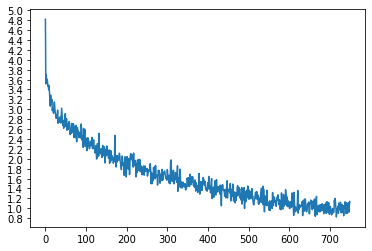

In [26]:
hidden_size = 256
encoder1 = EncoderRnn(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRnn(hidden_size, output_lang.n_words, dropout_p = 0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [27]:
evaluateRandomly(encoder1, attn_decoder1)

> vous etes important .
= you are important .
< you are important . <EOS>

> elle est toujours gentille a l egard de tout le monde .
= she is always kind to everyone .
< she is always kind to everyone . <EOS>

> je n ai pas faim du tout .
= i m not even a little hungry .
< i m not hungry hungry all . <EOS>

> nous sommes concurrents pas partenaires .
= we re competitors not partners .
< we re not partners to . <EOS>

> il est a son cote .
= he s at her side .
< he is on the side . <EOS>

> je ne vous en empeche pas .
= i m not stopping you .
< i m not stopping to . <EOS>

> vous n etes pas tres bonnes .
= you re not very good .
< you re not very good . <EOS>

> je suis connu .
= i m famous .
< i m famous . <EOS>

> vous etes trop suspicieux de tout .
= you re too suspicious about everything .
< you re too suspicious about everything . <EOS>

> je ne te le dis pas .
= i m not telling you .
< i m not talking to you . <EOS>



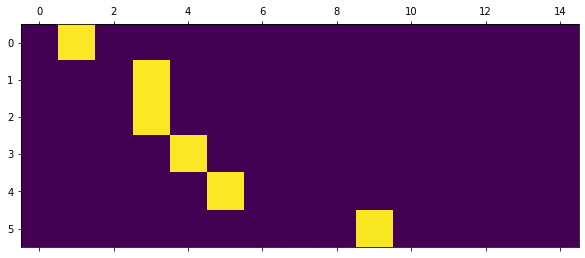

In [28]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she s three years younger than years younger years . <EOS>


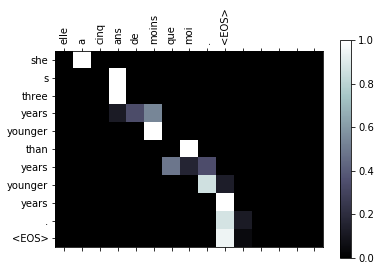

input = elle est trop petit .
output = she s too too . <EOS>


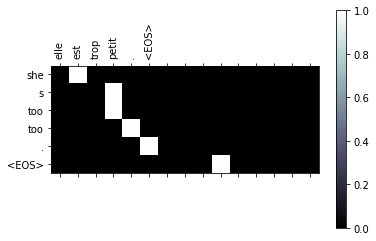

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


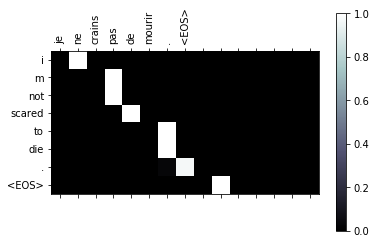

input = c est un jeune directeur plein de talent .
output = he s a talented talented of <EOS>


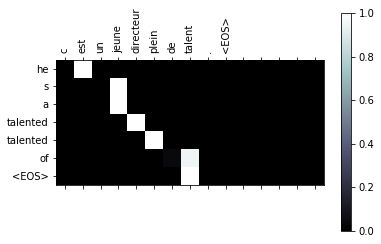

In [29]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = je me souviens de toi .
output = i m looking forward to you . <EOS>


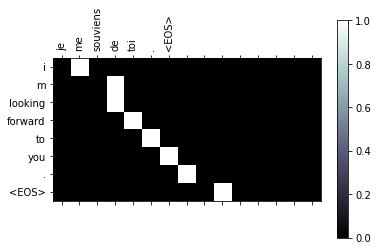

In [30]:
evaluateAndShowAttention("je me souviens de toi .")

input = je suis a la maison .
output = i m home . <EOS>


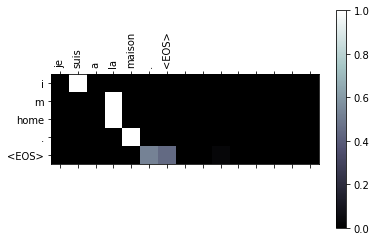

In [31]:
evaluateAndShowAttention("je suis a la maison .")

In [38]:
torch.save(encoder1, './result')

/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type EncoderRnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
